In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 

In [2]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_tracking = compute_orientation(df_tracking)
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

In [3]:
print(df_play.dropBackType.unique())

['TRADITIONAL' 'SCRAMBLE_ROLLOUT_RIGHT' 'DESIGNED_ROLLOUT_RIGHT' nan
 'SCRAMBLE' 'DESIGNED_ROLLOUT_LEFT' 'UNKNOWN' 'DESIGNED_RUN'
 'SCRAMBLE_ROLLOUT_LEFT']


In [ ]:
gameId = 2021090900
playId = 97
selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()    
tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

print(selected_tracking_df.columns)
print(selected_tracking_df[["displayName","frameId","x","y","dis"]])

In [11]:
animate_play(df_tracking,df_play,df_players,df_pffScoutingData,2021090900, 2330, displayZone=True, displayOrientations=False).show()

In [ ]:
gameId = 2021090900
playId = 97

playIds = df_play[df_play.gameId==gameId].playId.unique()
playIds.sort()
for playId in playIds[:5]:
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()    
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
    selected_tracking_df = beaten_by_defender(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)


    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    if selected_play_df.empty :
        print(playId)
        continue
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    print(f" PlayId : {playId} - {playDescription}")
    aire_t = list()
    if 'pass_forward' in selected_tracking_df.event.unique():
        eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
    else :
        eventFrame = 1000
    for frameId in sorted_frame_list:
        #if eventFrame == frameId :
        #    break
        selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
        offensive_points = get_Oline_position(selected_frame_df)
        defensive_points = get_Dline_position(selected_frame_df)
        QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
        region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
        aire_t.append(pocketArea(region_polys, region_pts, players_points))

    plt.plot(aire_t)
    plt.vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
    plt.show()
    

In [ ]:
gameId = 2021090900

playIds = df_play[df_play.gameId==gameId].playId.unique()
playIds.sort()
for playId in tqdm(playIds):
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()  
    if 'SCRAMBLE' in selected_play_df.dropBackType.unique():  
        tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
        tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
        selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
        selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
        selected_tracking_df = beaten_by_defender(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)

        sorted_frame_list = selected_tracking_df.frameId.unique()
        sorted_frame_list.sort()
        if selected_play_df.empty :
            print(playId)
            continue
        line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
        playDescription = selected_play_df.playDescription.values[0]
        print(f" PlayId : {playId} - {playDescription}")

        QB_dis_list = list(selected_tracking_df[selected_tracking_df.officialPosition == "QB"].dis)
        QB_dis_covered = [QB_dis_list[0]] + [np.sum(QB_dis_list[:k]) for k in range(1,len(QB_dis_list))]
        aire_t = list()

        for frameId in sorted_frame_list:
            #if eventFrame == frameId :
            #    break
            selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
            offensive_points = get_Oline_position(selected_frame_df)
            defensive_points = get_Dline_position(selected_frame_df)
            QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
            region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
            aire_t.append(pocketArea(region_polys, region_pts, players_points))
        fig, ax = plt.subplots(2,1, figsize=(7,14))
        ax[0].plot(sorted_frame_list, aire_t)
        
        if 'pass_forward' in selected_tracking_df.event.unique():
            eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
            ax[0].vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
        else :
            eventFrame = 1000
        ax[1].plot(sorted_frame_list, QB_dis_covered, color = 'red')
        plt.show()
    

Total n° of plays : 8557
n° of scramble plays : 1047


  0%|          | 0/1047 [00:00<?, ?it/s]

 PlayId : 2021090900 - 735 - (2:45) (Shotgun) D.Prescott pass short right to M.Gallup ran ob at TB 29 for 8 yards.


/tmp/ipykernel_62116/3737302287.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



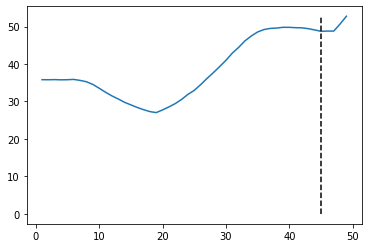

  0%|          | 1/1047 [00:06<1:47:00,  6.14s/it]

 PlayId : 2021090900.0 - 1425.0 - (9:04) D.Prescott pass short right to B.Jarwin pushed ob at TB 33 for 6 yards (J.Pierre-Paul). Tampa Bay challenged the pass completion ruling, and the play was Upheld. The ruling on the field stands. (Timeout #1.)


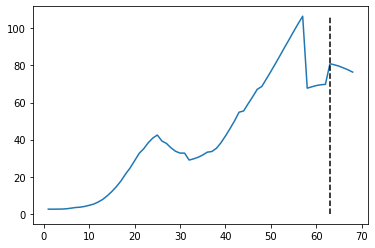

  0%|          | 2/1047 [00:13<1:56:37,  6.70s/it]

 PlayId : 2021090900.0 - 2279.0 - (1:11) (Shotgun) D.Prescott sacked at TB 33 for -12 yards (S.Barrett).


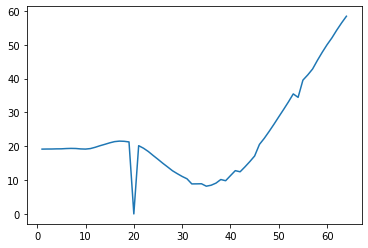

  0%|          | 3/1047 [00:20<2:02:38,  7.05s/it]

 PlayId : 2021090900.0 - 2330.0 - (:28) (Shotgun) D.Prescott scrambles left end pushed ob at TB 42 for 1 yard (S.Barrett; W.Gholston). TB-W.Gholston was injured during the play. His return is Questionable. 


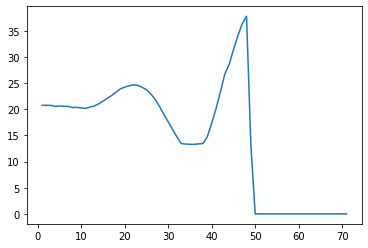

  0%|          | 4/1047 [00:28<2:06:14,  7.26s/it]

In [4]:
print(f'Total n° of plays : {len(df_play)}')
scramble_mask = "'SCRAMBLE' in dropBackType | 'SCRAMBLE_ROLLOUT_RIGHT' in dropBackType | 'SCRAMBLE_ROLLOUT_LEFT' in dropBackType"
scramble_plays = df_play.query(scramble_mask)#[["gameId","playId","dropBackType"]]
print(f'n° of scramble plays : {len(scramble_plays)}')
for scramble_id in tqdm(range(len(scramble_plays))):

    scramble_play = scramble_plays.iloc[scramble_id].playId
    scramble_game = scramble_plays.iloc[scramble_id].gameId

    selected_play_df = df_play[(df_play.playId==scramble_play)&(df_play.gameId==scramble_game)].copy()  
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==scramble_play)&(tracking_players_df.gameId==scramble_game)].copy()
    selected_tracking_df = beaten_by_defender(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    selected_tracking_df = scramble(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    if selected_play_df.empty :
        print(playId)
        continue
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    print(f" PlayId : {scramble_game} - {scramble_play} - {playDescription}")

    QB_dis_list = list(selected_tracking_df[selected_tracking_df.officialPosition == "QB"].dis)
    QB_dis_covered = [QB_dis_list[0]] + [np.sum(QB_dis_list[:k]) for k in range(1,len(QB_dis_list))]
    aire_t = list()

    for frameId in sorted_frame_list:
        #if eventFrame == frameId :
        #    break
        selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
        offensive_points = get_Oline_position(selected_frame_df)
        defensive_points = get_Dline_position(selected_frame_df)
        QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
        region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
        aire_t.append(pocketArea(region_polys, region_pts, players_points))
    aire_min_during_scramble = np.min(aire_t)
    scramble_plays.loc[scramble_id, 'scrambleArea'] = aire_min_during_scramble
#print(scramble_plays[['gameId','playId','scrambleArea']])

    plt.plot(sorted_frame_list, aire_t)

    if 'pass_forward' in selected_tracking_df.event.unique():
        eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
        plt.vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
    else :
        eventFrame = 1000
    plt.show()


In [9]:
df_area = pd.read_csv("data/area/week1.csv")
playIds = df_area.playId.unique()
print(playIds)
event_list = list()
te_list = list()
Ae_list = list()
tc_list = list()
Ac_list = list()

for playId in playIds:
    print(playId)
    gameId = df_area[df_area.playId == playId].gameId.unique()[0]
    print(gameId)
    selected_area_df = df_area[(df_area.playId==playId)&(df_area.gameId==gameId)].copy() 
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()  
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
    selected_tracking_df = beaten_by_defender(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    selected_tracking_df = scramble(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    #event, te = compute_t_event(gameId, playId, selected_play_df, df_pffScoutingData, selected_tracking_df)
    #Ae = selected_area_df[selected_area_df.frameId == te].Area
    #Ac = np.max(selected_area_df.Area)
    #tc = selected_area_df[selected_area_df.Area == Ac].frameId
#
    #event_list.append(event)
    #te_list.append(te)
    #Ae_list.append(Ae)
    #tc_list.append(tc)
    #Ac_list.append(Ac)

    event_list.append(playId)






    

[  97  137  187 ... 4736 4765 4845]
97
2021090900
    Unnamed: 0  frameId       Area  playId      gameId
0            0        1  22.319900      97  2021090900
1            0        2  22.162750      97  2021090900
2            0        3  22.160150      97  2021090900
3            0        4  22.453350      97  2021090900
4            0        5  22.727850      97  2021090900
5            0        6  22.975450      97  2021090900
6            0        7  23.403950      97  2021090900
7            0        8  23.958700      97  2021090900
8            0        9  24.549600      97  2021090900
9            0       10  25.111250      97  2021090900
10           0       11  25.604200      97  2021090900
11           0       12  26.094750      97  2021090900
12           0       13  26.666900      97  2021090900
13           0       14  27.512500      97  2021090900
14           0       15  28.078050      97  2021090900
15           0       16  28.625650      97  2021090900
16           0 

KeyboardInterrupt: 